1) Load Libraries and Data

In [24]:
import missingno as msno
import matplotlib.pyplot as plt
import pandas as pd

# Load the CSV file into a DataFrame with low_memory=False to avoid DtypeWarning
data = pd.read_csv('msna_data.csv', low_memory=False)

2) Data Exploration 

In [25]:
# Explore the data
print("\nInformation about the DataFrame:")
print(data.info())

print("\nSummary statistics of the DataFrame:")
print(data.describe(include='all'))

# Display the data types of each column
print("\nData types of each column:")
print(data.dtypes)


Information about the DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329443 entries, 0 to 329442
Columns: 199 entries, country to weight
dtypes: float64(105), int64(65), object(29)
memory usage: 500.2+ MB
None

Summary statistics of the DataFrame:
       country           year      msna ADM2_PCODE ADM1_PCODE  \
count   329443  329443.000000    329443     107016     116498   
unique      19            NaN        41        630        132   
top        drc            NaN  drc-2023  NER004005     NER006   
freq     53671            NaN     40790       1274       4437   
mean       NaN    2022.116645       NaN        NaN        NaN   
std        NaN       0.784639       NaN        NaN        NaN   
min        NaN    2021.000000       NaN        NaN        NaN   
25%        NaN    2021.000000       NaN        NaN        NaN   
50%        NaN    2022.000000       NaN        NaN        NaN   
75%        NaN    2023.000000       NaN        NaN        NaN   
max        NaN    2023

3) Data Preparation and Feature Engineering

3.1 Drop columns not needed and those with too many NAs, filter NAs for response variable


Shape of the filtered DataFrame:
(268511, 199)

Variables to include in model:
['water_source', 'shelter_type', 'lcsi_cat', 'hoh_age', 'child_adult_ratio', 'num_children', 'num_adults', 'children_0_2', 'children_3_5', 'children_6_12', 'children_13_17', 'adults_18_40', 'adults_41_59', 'adults_60_plus', 'fcs_score', 'hhs_score', 'rcsi_score', 'fsl_fc_cell', 'wgq_dis_4_n', 'wgq_dis_3_n', 'wgq_dis_2_n', 'fatalities_3m', 'events_3m', 'fatalities_6m', 'events_6m', 'fatalities_1y', 'events_1y', 'child_sep_severity_family_reun_required', 'displ_status_general_idp', 'displ_status_general_non_displaced', 'displ_status_general_refugee', 'displ_status_general_NA', 'displ_status_specific_idp_non_site', 'displ_status_specific_idp_returnee', 'displ_status_specific_idp_site', 'displ_status_specific_NA', 'hoh_gender_female', 'hoh_gender_male', 'hoh_gender_other', 'hoh_gender_NA', 'single_caregiver_no', 'single_caregiver_yes', 'single_caregiver_NA', 'received_assistance_3m_dnk', 'received_assistance_3m

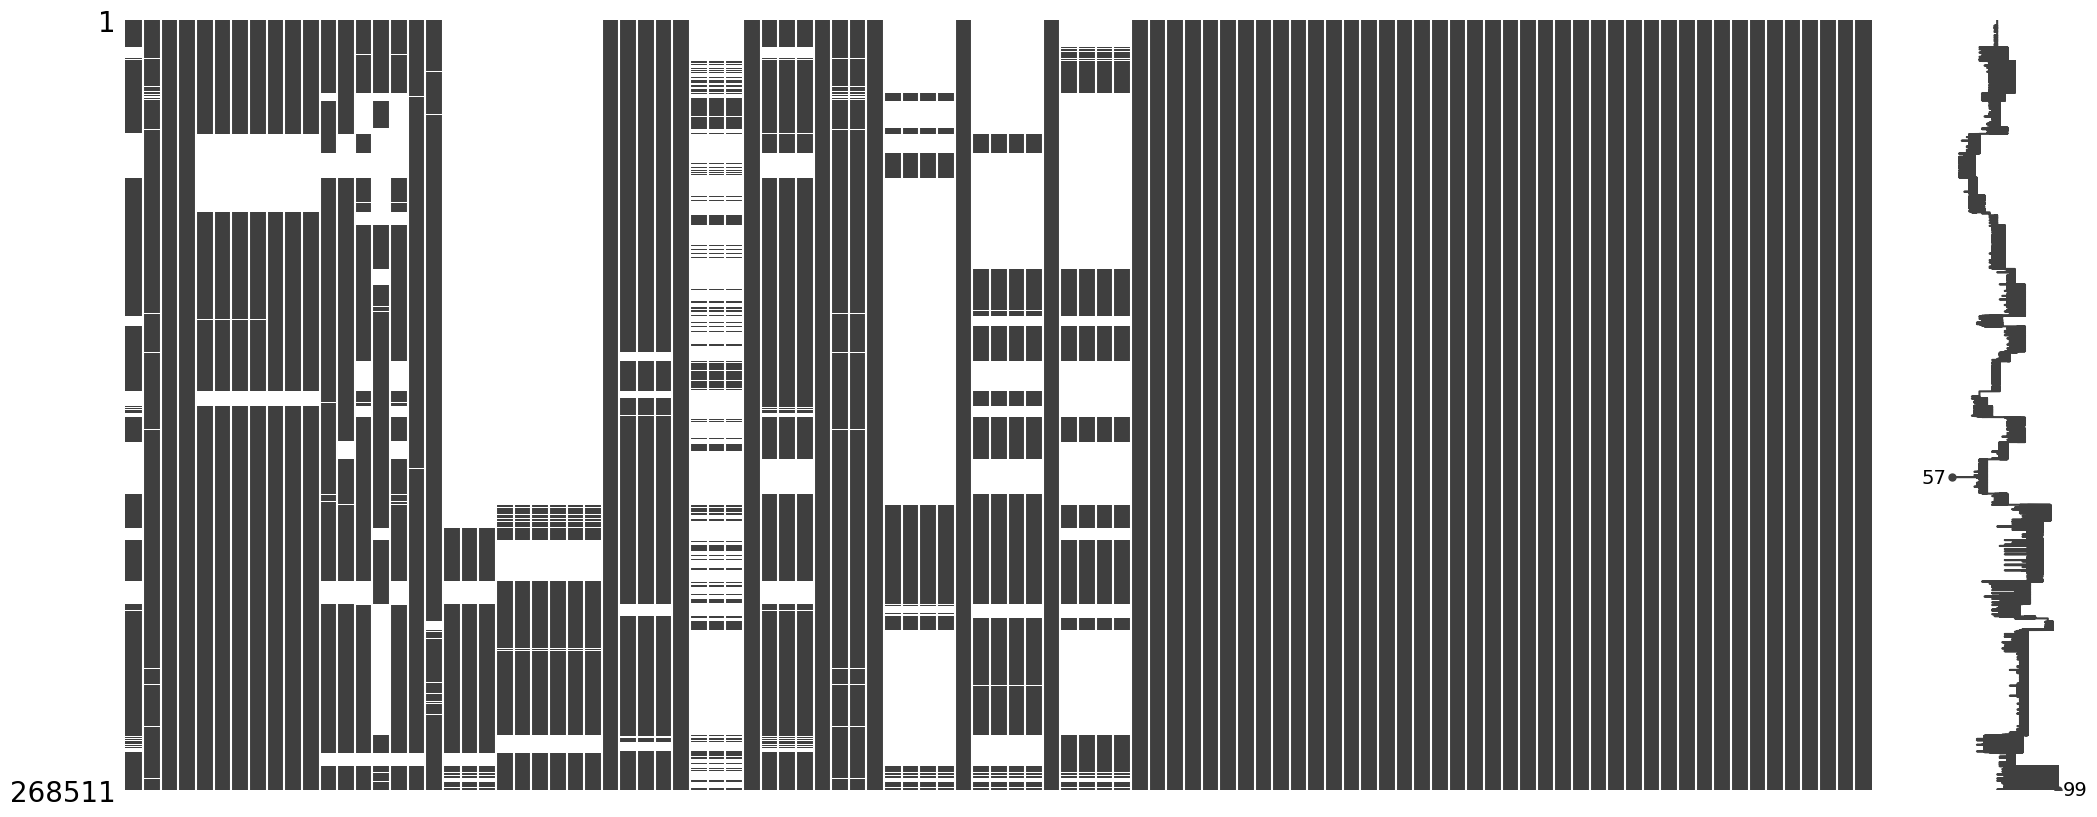

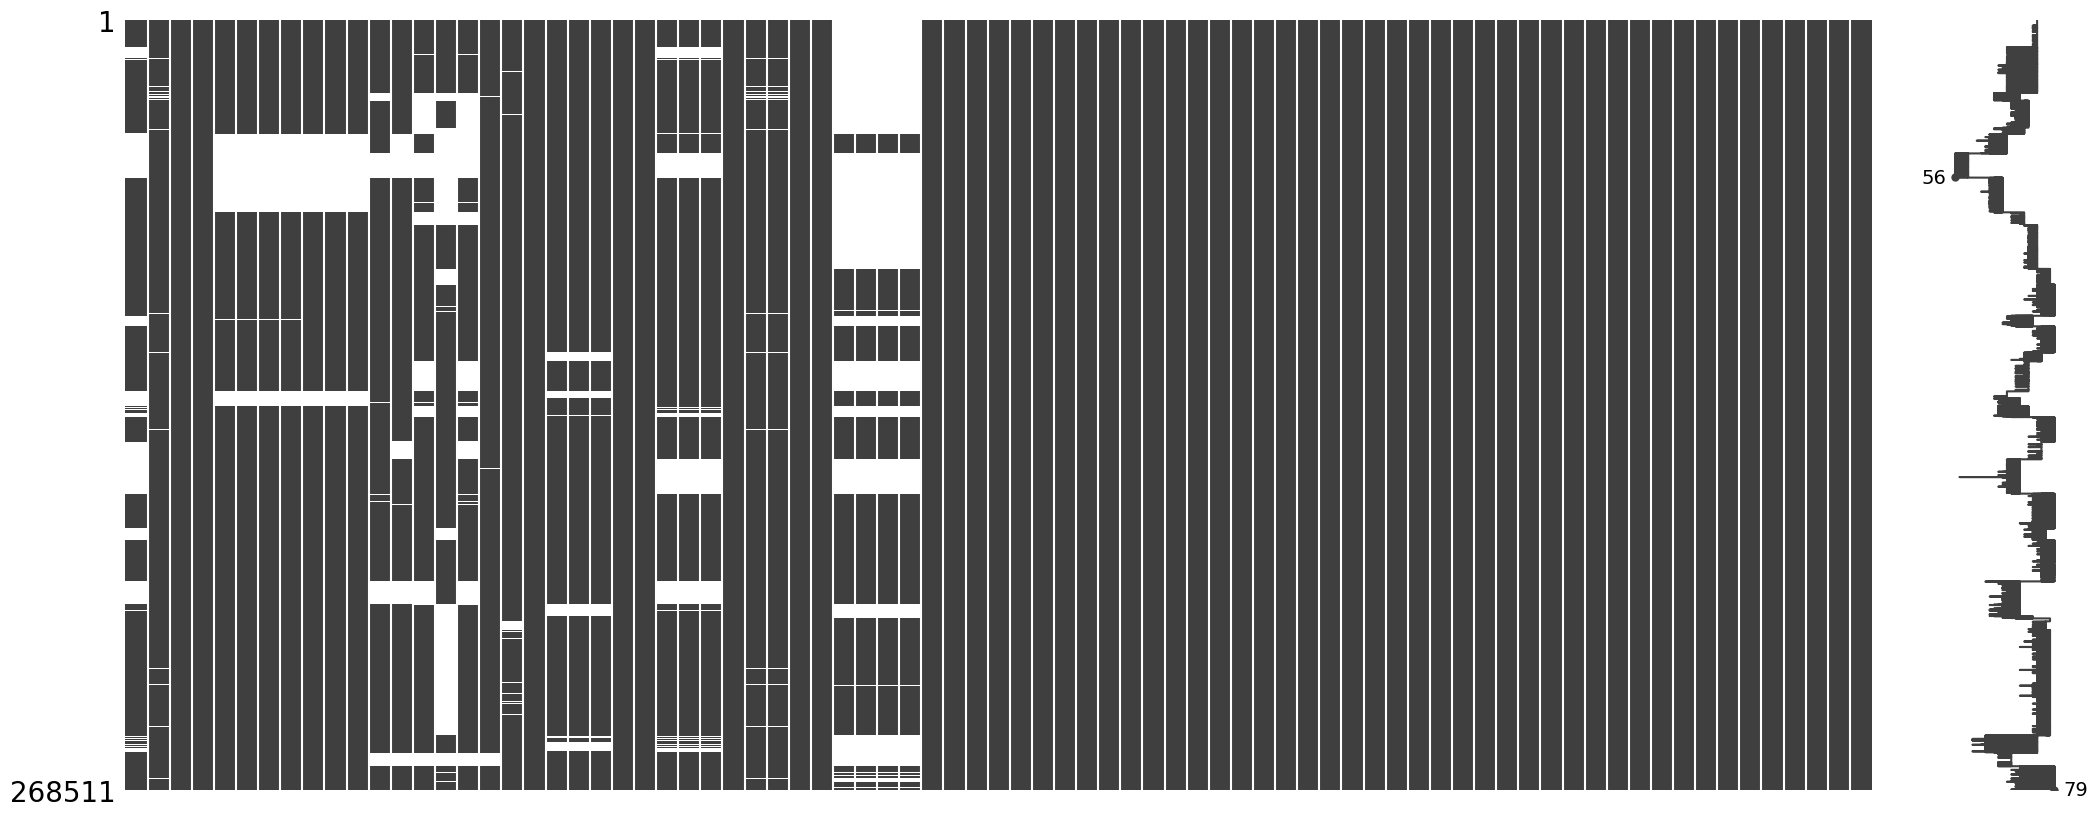


DataFrame after dropping '_NA' variables with no other variable with the same stem:
<class 'pandas.core.frame.DataFrame'>
Index: 268511 entries, 0 to 329442
Data columns (total 76 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   hoh_age                                  204282 non-null  float64
 1   child_adult_ratio                        264081 non-null  float64
 2   num_children                             268510 non-null  float64
 3   num_adults                               268505 non-null  float64
 4   children_0_2                             235209 non-null  float64
 5   children_3_5                             235209 non-null  float64
 6   children_6_12                            235209 non-null  float64
 7   children_13_17                           235209 non-null  float64
 8   adults_18_40                             235498 non-null  float64
 9   adults_41_59           

In [26]:
# Filter out rows with missing values in the 'child_sep_severity' column
data_filtered = data.dropna(subset=['child_sep_severity'])

# Display the shape of the filtered DataFrame
print("\nShape of the filtered DataFrame:")
print(data_filtered.shape)

# Load CSV file with variables to include in model
vars_analysis = pd.read_csv('vars_analysis.csv')['variable'].tolist()

# Ensure 'variable' column is correctly extracted
print("\nVariables to include in model:")
print(vars_analysis)

# Drop columns not in vars_analysis
data_select = data_filtered.drop(columns=[col for col in data_filtered.columns if col not in vars_analysis])

print("\nDataFrame after dropping variables:")
print(data_select.info())

# Identify variables with more than 50% missing values
missing_percentage = data_select.isnull().mean() * 100
columns_with_many_missing = missing_percentage[missing_percentage > 50].index.tolist()

print("\nColumns with more than 50% missing values:")
print(columns_with_many_missing)

# Show number of NAs and percentage for each of the identified variables
missing_data_summary = data_select[columns_with_many_missing].isnull().sum().to_frame(name='Number of NAs')
missing_data_summary['Percentage'] = missing_percentage[columns_with_many_missing]

print("\nMissing data summary for columns with more than 50% missing values:")
print(missing_data_summary)

# Assess missing data patterns
print("\nMissing data patterns:")

# Visualize missing data matrix
msno.matrix(data_select)
plt.show()

# Drop columns with over 50% NAs
data_select_na = data_select.drop(columns=columns_with_many_missing)

# Visualize missing data matrix
msno.matrix(data_select_na)
plt.show()

# Identify and drop variables ending with '_NA' that have no other variable with the same stem
na_columns = [col for col in data_select_na.columns if col.endswith('_NA')]
stems = {col[:-3] for col in na_columns}
columns_to_drop = [col for col in na_columns if not any(other_col.startswith(col[:-3]) and other_col != col for other_col in data_select_na.columns)]

columns_before_na_suffix_drop = set(data_select_na.columns)
data_select_na = data_select_na.drop(columns=columns_to_drop)
dropped_columns_na_suffix = columns_before_na_suffix_drop - set(data_select_na.columns)

print("\nDataFrame after dropping '_NA' variables with no other variable with the same stem:")
print(data_select_na.info())
print("\nDropped '_NA' variables with no other variable with the same stem:")
print(dropped_columns_na_suffix)


# Check which variables from vars_analysis are no longer in the data
missing_vars = [var for var in vars_analysis if var not in data_select_na.columns]

print("\nVariables from vars_analysis no longer in the data:")
print(missing_vars)

3.2 Change one-hot to label encoding for ordinal variables

In [27]:
# Load the new_labels CSV file
new_labels = pd.read_csv('new_labels.csv', usecols=['variable', 'label_old', 'label_new'])

print("\nLoaded new_labels DataFrame:")
print(new_labels.head())

# Create a copy of data_select_na to apply changes
data_ord = data_select_na.copy()

# Apply the label mapping to the data_ord DataFrame
for _, row in new_labels.iterrows():
    variable = row['variable']
    label_old = row['label_old']
    label_new = int(row['label_new'])  # Convert label_new to integer
    
    if variable in data_ord.columns:
        data_ord[variable] = data_ord[variable].replace(label_old, label_new)

# Define recoded_variables
recoded_variables = new_labels['variable'].unique()

# Convert the recoded variables to integer type
for variable in recoded_variables:
    if variable in data_ord.columns:
        data_ord[variable] = data_ord[variable].fillna(pd.NA).astype('Int64')  # Fill NaNs with pd.NA before converting

# Check if recoded_variables are in data_ord
variables_in_data_ord = all(variable in data_ord.columns for variable in recoded_variables)
print(f"All recoded variables are in data_ord: {variables_in_data_ord}")

# Identify which variables are not in data_ord
missing_variables = [variable for variable in recoded_variables if variable not in data_ord.columns]
print(f"Variables not in data_ord: {missing_variables}")

# Display the first few rows of the recoded variables in the data_ord DataFrame
print("\nRecoded variables in data_ord DataFrame:")
print(data_ord[recoded_variables].head())

# Display the variable types of the recoded variables
print("\nVariable types of recoded variables:")
print(data_ord[recoded_variables].dtypes)


Loaded new_labels DataFrame:
       variable   label_old  label_new
0  shelter_type    adequate          1
1  shelter_type  inadequate          2
2  shelter_type  no_shelter          3
3  water_source    improved          1
4  water_source  unimproved          2


C:\Users\jasper.linke\AppData\Local\Temp\ipykernel_12464\367835001.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_ord[variable] = data_ord[variable].replace(label_old, label_new)


All recoded variables are in data_ord: True
Variables not in data_ord: []

Recoded variables in data_ord DataFrame:
   shelter_type  water_source  lcsi_cat
0             1             1         1
1             1             1         1
3             1             1         2
4             1             1         1
6             1             2         3

Variable types of recoded variables:
shelter_type    Int64
water_source    Int64
lcsi_cat        Int64
dtype: object


3.3 Store all dummy variables as integers

In [35]:
import pandas as pd

# Load the vars_analysis.csv to identify variable types
vars_analysis = pd.read_csv('vars_analysis.csv', usecols=['variable', 'type'])
dummy_variables = vars_analysis[vars_analysis['type'] == 'dummy']['variable'].tolist()

# Copy data_ord to data_dum
data_dum = data_ord.copy()

# Filter dummy variables to include only those present in data_dum
dummy_variables = [var for var in dummy_variables if var in data_dum.columns]

# Ensure all dummy variables are integers, allowing for NaN values
data_dum[dummy_variables] = data_dum[dummy_variables].astype(pd.Int64Dtype())

# Print the names of all dummy variables
print("\nNames of all dummy variables in DataFrame:")
print(dummy_variables)

# Display the first few rows of all dummy variables to confirm they are integers
print("\nAll dummy variables in DataFrame:")
print(data_dum[dummy_variables].head())

# Describe the dummy variables
print("\nDescription of all dummy variables in DataFrame:")
print(data_dum[dummy_variables].describe())


Names of all dummy variables in DataFrame:
['child_sep_severity_family_reun_required', 'displ_status_general_idp', 'displ_status_general_non_displaced', 'displ_status_general_refugee', 'displ_status_general_NA', 'hoh_gender_female', 'hoh_gender_male', 'hoh_gender_other', 'hoh_gender_NA', 'single_caregiver_no', 'single_caregiver_yes', 'single_caregiver_NA', 'received_assistance_6m_dnk', 'received_assistance_6m_dwta', 'received_assistance_6m_no', 'received_assistance_6m_yes', 'received_assistance_6m_NA', 'msna_afg-2021', 'msna_afg-2022', 'msna_bfa-2021', 'msna_bfa-2022', 'msna_bfa-2023', 'msna_bgd-hosts-2023', 'msna_bgd-refugees-2023', 'msna_bgd_hc-2021', 'msna_bgd_r-2021', 'msna_car-2021', 'msna_car-2022', 'msna_col-2021', 'msna_col-2022', 'msna_drc-2021', 'msna_drc-2022', 'msna_drc-2023', 'msna_hti-2022', 'msna_hti-admin1-2023', 'msna_hti-pap-2023', 'msna_irq-2021', 'msna_irq-2022', 'msna_ken-2021', 'msna_ken-2022', 'msna_ken-2023', 'msna_lbn-2021', 'msna_lby-2021', 'msna_lby-2022', '

3.4 Remove outliers

I am using the modified z-scores because IQR would remove more than 50% of values in some cases. Modified z-scores can be used with highly-skewed data.

In [46]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Filter variables to include only those present in data_dum
dummy_variables = [var for var in dummy_variables if var in data_dum.columns]
ordinal_variables = [var for var in ordinal_variables if var in data_dum.columns]
numerical_variables = [var for var in numerical_variables if var in data_dum.columns]

# Print the names of all dummy variables
print("\nDummy variables:")
print(dummy_variables)

# Print the names of numerical variables
print("\nNumerical variables:")
print(numerical_variables)

# Display summary statistics before outlier removal
print("\nSummary statistics before removing outliers:")
print(data_dum.describe())

# Separate the dummy and ordinal variables
dummy_data = data_dum[dummy_variables]
ordinal_data = data_dum[ordinal_variables]

# Detect and cap outliers using modified z-score method
def cap_outliers(df, columns, threshold=3.5):
    for col in columns:
        median = df[col].median()
        mad = np.median(np.abs(df[col] - median))
        modified_z_scores = 0.6745 * (df[col] - median) / mad
        df.loc[:, col] = df[col].where(abs(modified_z_scores) < threshold, median)
    return df

# Create a copy of data_dum for outlier handling
data_dum_copy = data_dum.copy()

# Cap outliers only in numerical columns
data_no_outliers = cap_outliers(data_dum_copy[numerical_variables], numerical_variables)

# Recombine the dummy, ordinal, and cleaned numerical variables
data_no_outliers = pd.concat([data_no_outliers, dummy_data, ordinal_data], axis=1)

# Display summary statistics after handling outliers
print("\nSummary statistics after handling outliers:")
print(data_no_outliers.describe())


Dummy variables:
['child_sep_severity_family_reun_required', 'displ_status_general_idp', 'displ_status_general_non_displaced', 'displ_status_general_refugee', 'displ_status_general_NA', 'hoh_gender_female', 'hoh_gender_male', 'hoh_gender_other', 'hoh_gender_NA', 'single_caregiver_no', 'single_caregiver_yes', 'single_caregiver_NA', 'received_assistance_6m_dnk', 'received_assistance_6m_dwta', 'received_assistance_6m_no', 'received_assistance_6m_yes', 'received_assistance_6m_NA', 'msna_afg-2021', 'msna_afg-2022', 'msna_bfa-2021', 'msna_bfa-2022', 'msna_bfa-2023', 'msna_bgd-hosts-2023', 'msna_bgd-refugees-2023', 'msna_bgd_hc-2021', 'msna_bgd_r-2021', 'msna_car-2021', 'msna_car-2022', 'msna_col-2021', 'msna_col-2022', 'msna_drc-2021', 'msna_drc-2022', 'msna_drc-2023', 'msna_hti-2022', 'msna_hti-admin1-2023', 'msna_hti-pap-2023', 'msna_irq-2021', 'msna_irq-2022', 'msna_ken-2021', 'msna_ken-2022', 'msna_ken-2023', 'msna_lbn-2021', 'msna_lby-2021', 'msna_lby-2022', 'msna_mli-2023', 'msna_mmr-

3.5 Standardize numerical data

In [ ]:
# Standardize the numerical variables (excluding dummy variables and categorical variables)
scaler = StandardScaler()
data_stand = data_no_outliers.copy()
data_stand[numerical_columns] = scaler.fit_transform(data_no_outliers[numerical_columns])

# Add back the categorical variables without standardizing them
common_categorical_vars = list(set(categorical_variables).intersection(data_dum.columns))
data_stand[common_categorical_vars] = data_dum[common_categorical_vars]

# Display summary statistics after standardization
print("\nSummary statistics after standardization:")
print(data_stand.describe())

# Histogram for hoh_age before standardization
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(data_no_outliers['hoh_age'], bins=30, alpha=0.7, color='blue')
plt.title('hoh_age before standardization')
plt.xlabel('hoh_age')
plt.ylabel('Frequency')

# Histogram for hoh_age after standardization
plt.subplot(1, 2, 2)
plt.hist(data_stand['hoh_age'], bins=30, alpha=0.7, color='green')
plt.title('hoh_age after standardization')
plt.xlabel('hoh_age')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

4. Feature Selection

In [17]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import ElasticNetCV
from boruta import BorutaPy
import shap

# Create a copy of data_stand for feature selection
data_fs = data_stand.copy()

# Separate features and target variable
X = data_fs.drop('child_sep_severity_family_reun_required', axis=1)
# Check unique values in the target variable
unique_classes = y.unique()
print(f"Unique classes in target variable: {unique_classes}")

# Ensure there are at least two classes
if len(unique_classes) > 1:
    X_rfe = rfe.fit_transform(X, y)
    print(f"Features after RFE: {X_rfe.shape[1]}")
else:
    print("The target variable does not contain at least two classes.")

# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
top_features_rf = X.columns[indices[:10]]
print(f"Top features according to Random Forest: {top_features_rf}")

### 5. Elastic Net Regularization ###
# Use Elastic Net for feature selection
elastic_net = ElasticNetCV(cv=5, random_state=42)
elastic_net.fit(X, y)
enet_coef = pd.Series(elastic_net.coef_, index=X.columns)
top_features_enet = enet_coef[enet_coef != 0].index
print(f"Top features according to Elastic Net: {top_features_enet}")

### 6. Boruta Algorithm ###
# Use the Boruta algorithm with a Random Forest model
boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)
boruta_selector.fit(X.values, y)

# Get the selected features from Boruta
boruta_features = X.columns[boruta_selector.support_].tolist()
print(f"Top features according to Boruta: {boruta_features}")

### 7. Mutual Information ###
# Use mutual information to select top features
mi = mutual_info_classif(X, y)
mi_features = X.columns[np.argsort(mi)[-10:]].tolist()  # Top 10 features by mutual information
print(f"Top features according to Mutual Information: {mi_features}")

### 8. SHAP Values for Feature Importance ###
# Use SHAP values to interpret the Random Forest model
explainer = shap.Explainer(rf, X)
shap_values = explainer(X)

# Display SHAP summary plot
shap.summary_plot(shap_values, X)

### Combine Results for the Most Relevant Features ###
# Combine selected features from all methods
combined_features = set(top_features_rf) | set(top_features_enet) | set(boruta_features) | set(mi_features)
print(f"Combined selected features: {combined_features}")

Unique classes in target variable: [0.]
The target variable does not contain at least two classes.


NameError: name 'rf' is not defined